In [1]:
#################################
## Wavelet CNN Stock Classifier 
#################################

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cwt
import pywt
from scipy import signal
from scipy import optimize

import torch
import torch.nn as nn
import tensorflow as tf
from timm.models.layers.conv2d_same import conv2d_same


from pathlib import Path
from IPython.display import Image
from IPython.display import display, HTML
from jupyterthemes.stylefx import set_nb_theme
from IPython.display import Image


display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

#Matplotlib params
plt.rcParams['figure.figsize'] = [23, 11] 
#Theme
set_nb_theme('oceans16')

In [2]:
## Wavelet transform
def wavelet_transform(x, wavelet=cwt.Morlet(), fmin=0, fmax=1000, dj=0.03, dt=1/365, show_sg=False, t='Days'):
    #Signal
    sig = x
    
    #Pytorch cwt
    sig_pt = torch.tensor(sig, dtype=torch.float32, device='cuda')
    sig_pt = torch.stack([sig_pt] * 1)  # 1 channels
    sig_pt = torch.stack([sig_pt] * 1)  # Batch size of 1

    pycwt = cwt.CWT(wavelet=wavelet, fmin=fmin, fmax=fmax, dj=dj, dt=dt) 
    out = pycwt(sig_pt) #GPU out
    out_cpu = out.cpu() #GPU tensor to CPU 
    scales = pycwt._scales
    freqs = pycwt._freqs
    print(f'Tensor shape:\n{out.shape}')
    print(f'Continuous wavelet transform:\n\n'\
          f'N = {len(sig)}\n'\
          f'J = {len(pycwt._scales)-1}\n'\
          f'Fourier periods in t=0...t={1/dt}:\n [{pycwt._scales[0]}...{pycwt._scales[-1]}]\n'\
          f'dj = {pycwt.dj}\n'\
          f'dt = {pycwt.dt}\n'\
         )
    
    #Fourier periods
    periods = []
    for i,j in enumerate((list(zip(scales,freqs)))):
        s = j[0]
        f = j[1]
        periods.append((j[1]))
        
    #Plot
    if show_sg == True:
        fig, axs = plt.subplots(1, 1, figsize=(24,12))
        axs.imshow(out_cpu[0, 0].numpy(), cmap='plasma', aspect="auto")
        axs.set_title('Scaleogram')
        axs.set_yticks(np.arange(len(periods)), ["%.3f" % i for i in periods])
        axs.set_yticks(axs.get_yticks()[::30])
        axs.set_ylabel(f'Fourier periods in {"%.0f" % (1/dt)} {t}\n')
        axs.set_xlabel(f'{t}')
    
    #Clear vram
    torch.cuda.empty_cache()
    
    return out_cpu

#Calculate geometric mean of set X relative return rates 
def get_geo_mean(X): #Numpy array or pandas series X
    n = len(X)
    gmr = (X + 1).prod()**(1/n) -1
    return gmr 

## Entropy
def get_entropy(list_values):
    counter = Counter(list_values).most_common()
    probs = [i[1]/len(list_values) for i in counter]
    ent = entropy(probs)
    return ent


#Harmonic mean of 1D array X
def harmonic_mean(X):
    n = len(X)
    hm = n / sum([1/i for i in X])
    return hm
    
#Split scalogram
def split_sg(sg, n_split=False):
    if n_split != False:
        n_split = n_split
    else:
        n_split = sg.shape[0]//5
        
    sg_split = np.array(np.split(sg, n_split, axis=0))
    scales_hm = {}
    for i,j in enumerate(sg_split):
        scales_hm[i] = [harmonic_mean(k) for k in j.T]
        
    return scales_hm

## Prepare data for model
def get_model_data(df, window:int, sg_period=int):
    df['sg_data'] = np.log(df.iloc[:,0]).diff().rolling(window=24).apply(lambda x: get_geo_mean(x))
    df.dropna(inplace=True)
    data = df.to_numpy().T
    X = []
    y = []
    for i in range(sg_period, data[0].size-window, 1):
        features = [np.array(feat) for feat in data[0][i:i+window]]
        sg = wavelet_transform(data[1][i-sg_period:i+window], wavelet=cwt.DOG(32))[0,0].numpy()
         
        features.append(sg)
        X.append(features)
        label = data[0][i+window]
        y.append(label)
        print(i)
    return tf.convert_to_tensor(X), tf.convert_to_tensor(y)
        
    
    
    
    

[*********************100%***********************]  1 of 1 completed


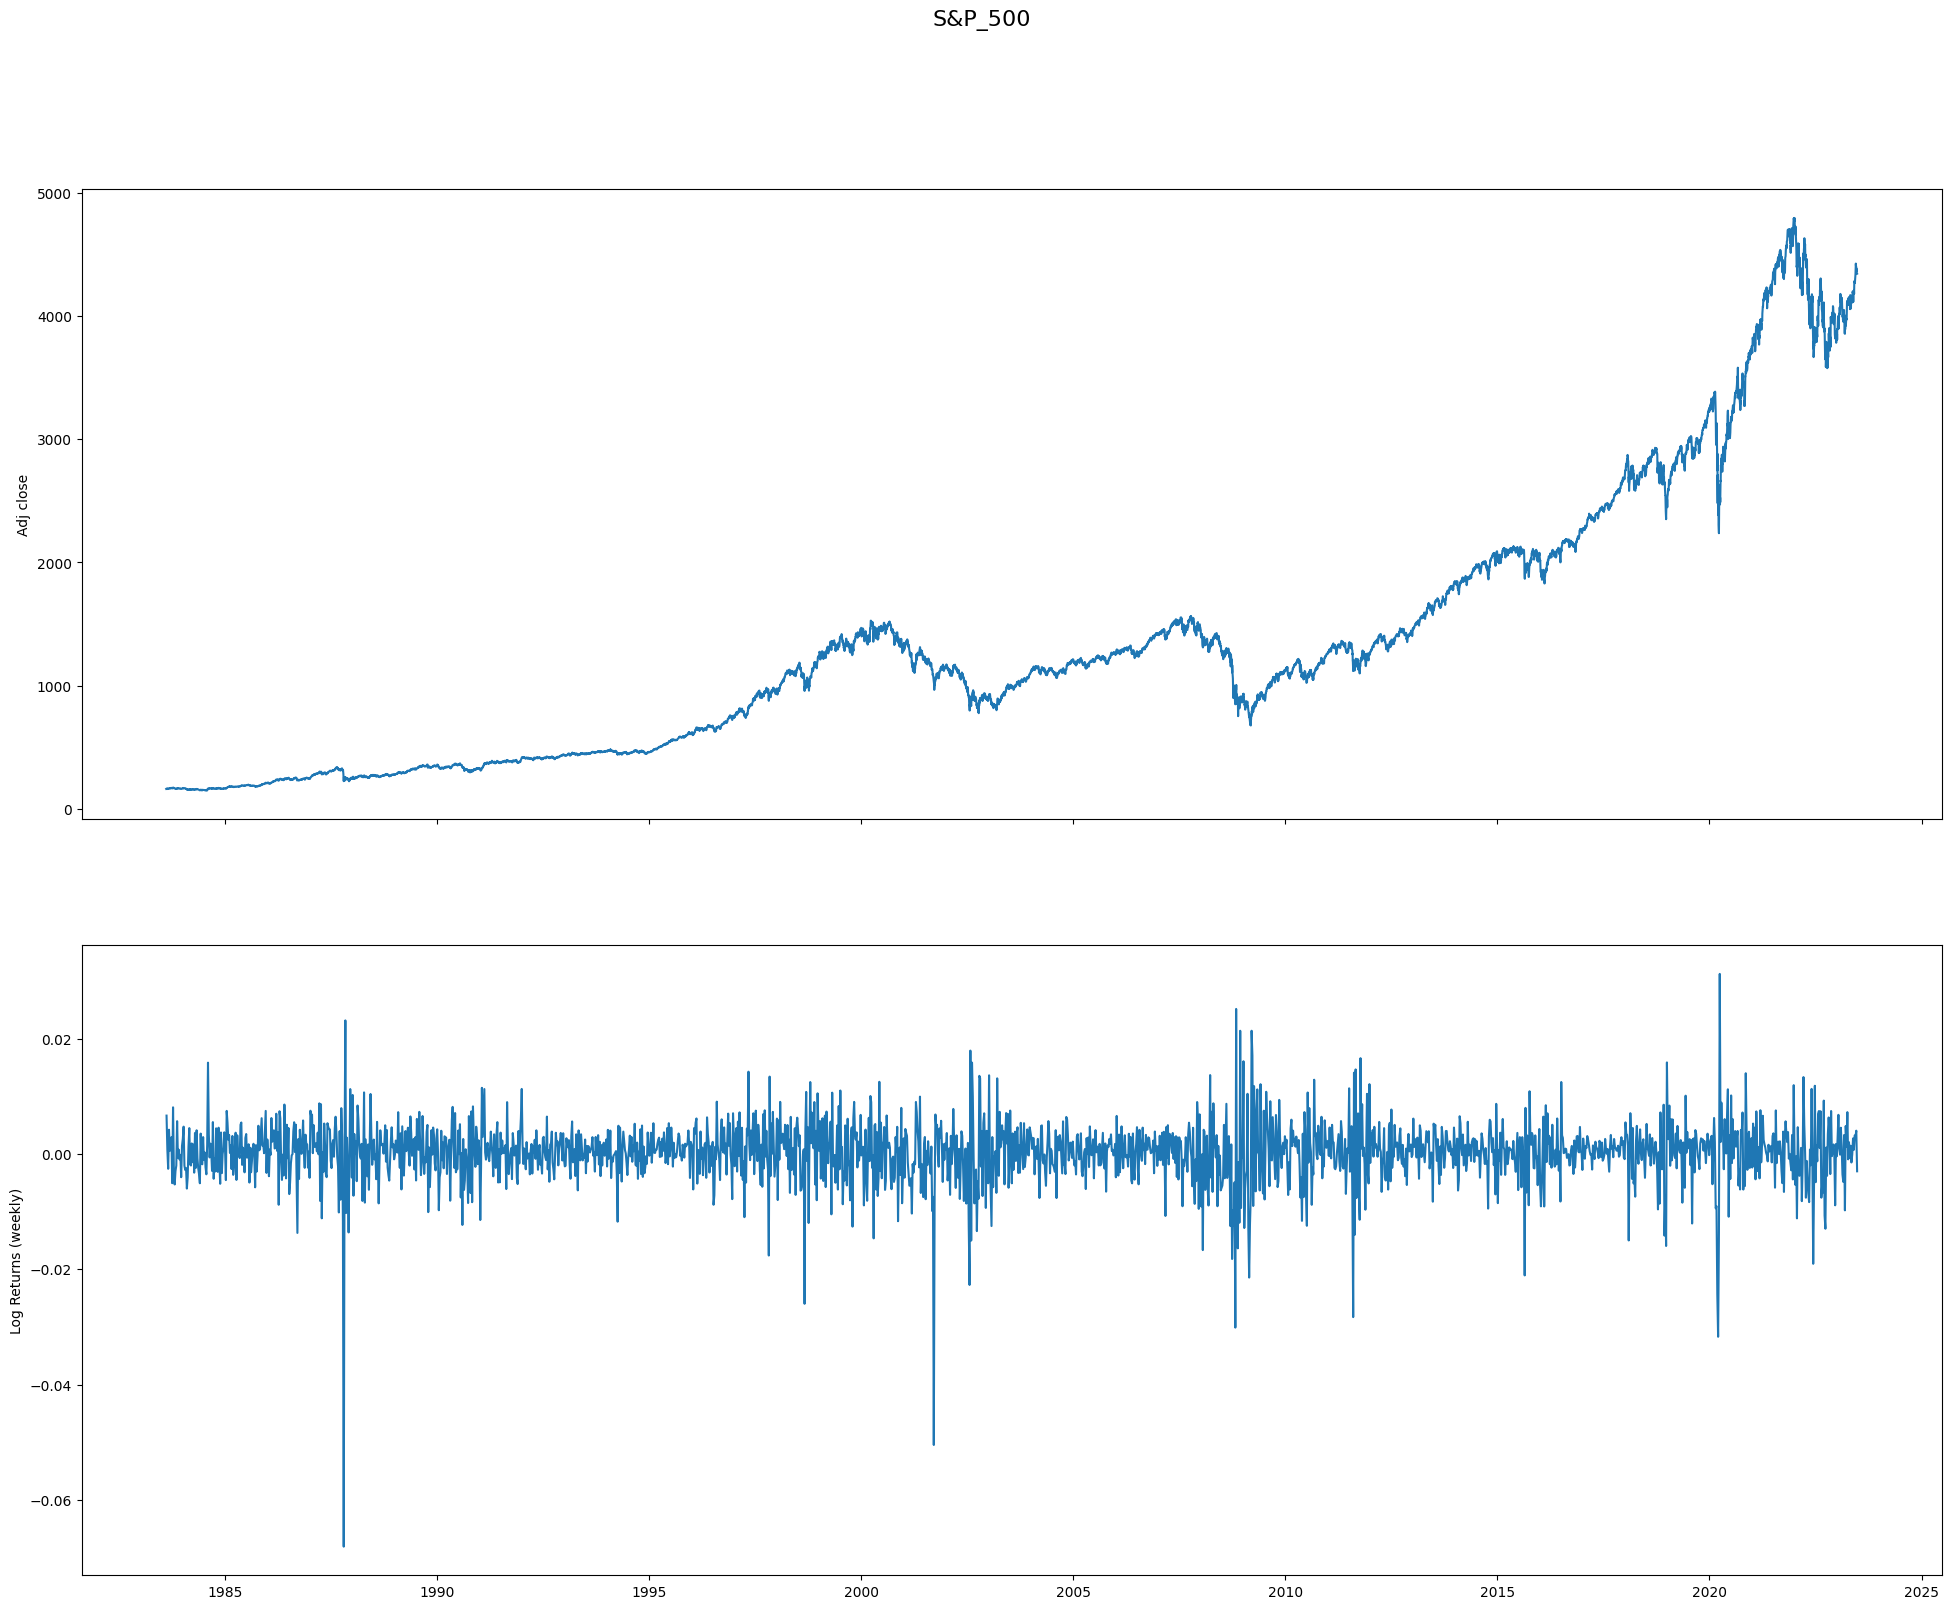

In [3]:
## Get dataset
import datetime
import yfinance as yf
import ta
import talib

#NASDAQ 
df = yf.download(tickers = "^GSPC",  # list of tickers
                  period = "40y",         # time period
                  interval = "1d",       # trading interval
                  prepost = False,       # download pre/post market hours data?
                  repair = True
                 )
df.rename(columns={'Adj Close': 'adj_close'}, inplace=True)
df['date'] = pd.to_datetime(df.index, format='%Y-%m-%d')
df['log_ret'] = np.log(df.adj_close).diff()
df['log_vol_diff'] = np.log(df.Volume).pct_change()
df['rsi_14'] = ta.momentum.rsi(df.adj_close, window=14) - 50
df['macd'] = talib.MACD(df.adj_close)[0]

df.dropna(inplace=True)

fig, axs = plt.subplots(2,1, sharex=True, figsize=(24,18))
fig.suptitle('S&P_500', fontsize=16)
axs[0].set_ylabel('Adj close')
axs[0].plot(df.adj_close)
axs[1].set_ylabel('Log Returns (weekly)')
axs[1].plot(df.log_ret.resample('W-MON').apply(lambda x: get_geo_mean(x)))


In [4]:
df

,Open,High,Low,Close,adj_close,Volume,date,log_ret,log_vol_diff,rsi_14,macd
Date,,,,,,,,,,,
1983-08-12,161.550003,162.600006,161.550003,162.160004,162.160004,71840000,1983-08-12,0.003831,0.000940,-6.950350,-1.533794
1983-08-15,162.220001,164.759995,162.220001,163.699997,163.699997,83200000,1983-08-15,0.009452,0.008115,-1.467452,-1.336786
1983-08-16,163.740005,163.839996,162.720001,163.410004,163.410004,71780000,1983-08-16,-0.001773,-0.008096,-2.396853,-1.190335
1983-08-17,163.580002,165.399994,163.429993,165.289993,165.289993,87800000,1983-08-17,0.011439,0.011137,3.782322,-0.912058
1983-08-18,165.289993,165.910004,163.550003,163.550003,163.550003,82280000,1983-08-18,-0.010583,-0.003550,-1.874547,-0.822443
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-20,4396.109863,4400.149902,4367.189941,4388.709961,4388.709961,4055790000,2023-06-20,-0.004746,-0.023133,18.636075,67.084463
2023-06-21,4380.009766,4386.220215,4360.140137,4365.689941,4365.689941,3709330000,2023-06-21,-0.005259,-0.004036,14.163771,64.457841
2023-06-22,4355.399902,4382.250000,4351.819824,4381.890137,4381.890137,3511000000,2023-06-22,0.003704,-0.002494,15.850194,62.957708


Tensor shape:
torch.Size([1, 1, 412, 10034])
Continuous wavelet transform:

N = 10034
J = 411
Fourier periods in t=0...t=365.0:
 [0.00530418251613365...27.30978657765311]
dj = 0.03
dt = 0.0027397260273972603

Tensor shape:
torch.Size([1, 1, 412, 10034])
Continuous wavelet transform:

N = 10034
J = 411
Fourier periods in t=0...t=365.0:
 [0.00530418251613365...27.30978657765311]
dj = 0.03
dt = 0.0027397260273972603

Tensor shape:
torch.Size([1, 1, 412, 10034])
Continuous wavelet transform:

N = 10034
J = 411
Fourier periods in t=0...t=365.0:
 [0.00530418251613365...27.30978657765311]
dj = 0.03
dt = 0.0027397260273972603



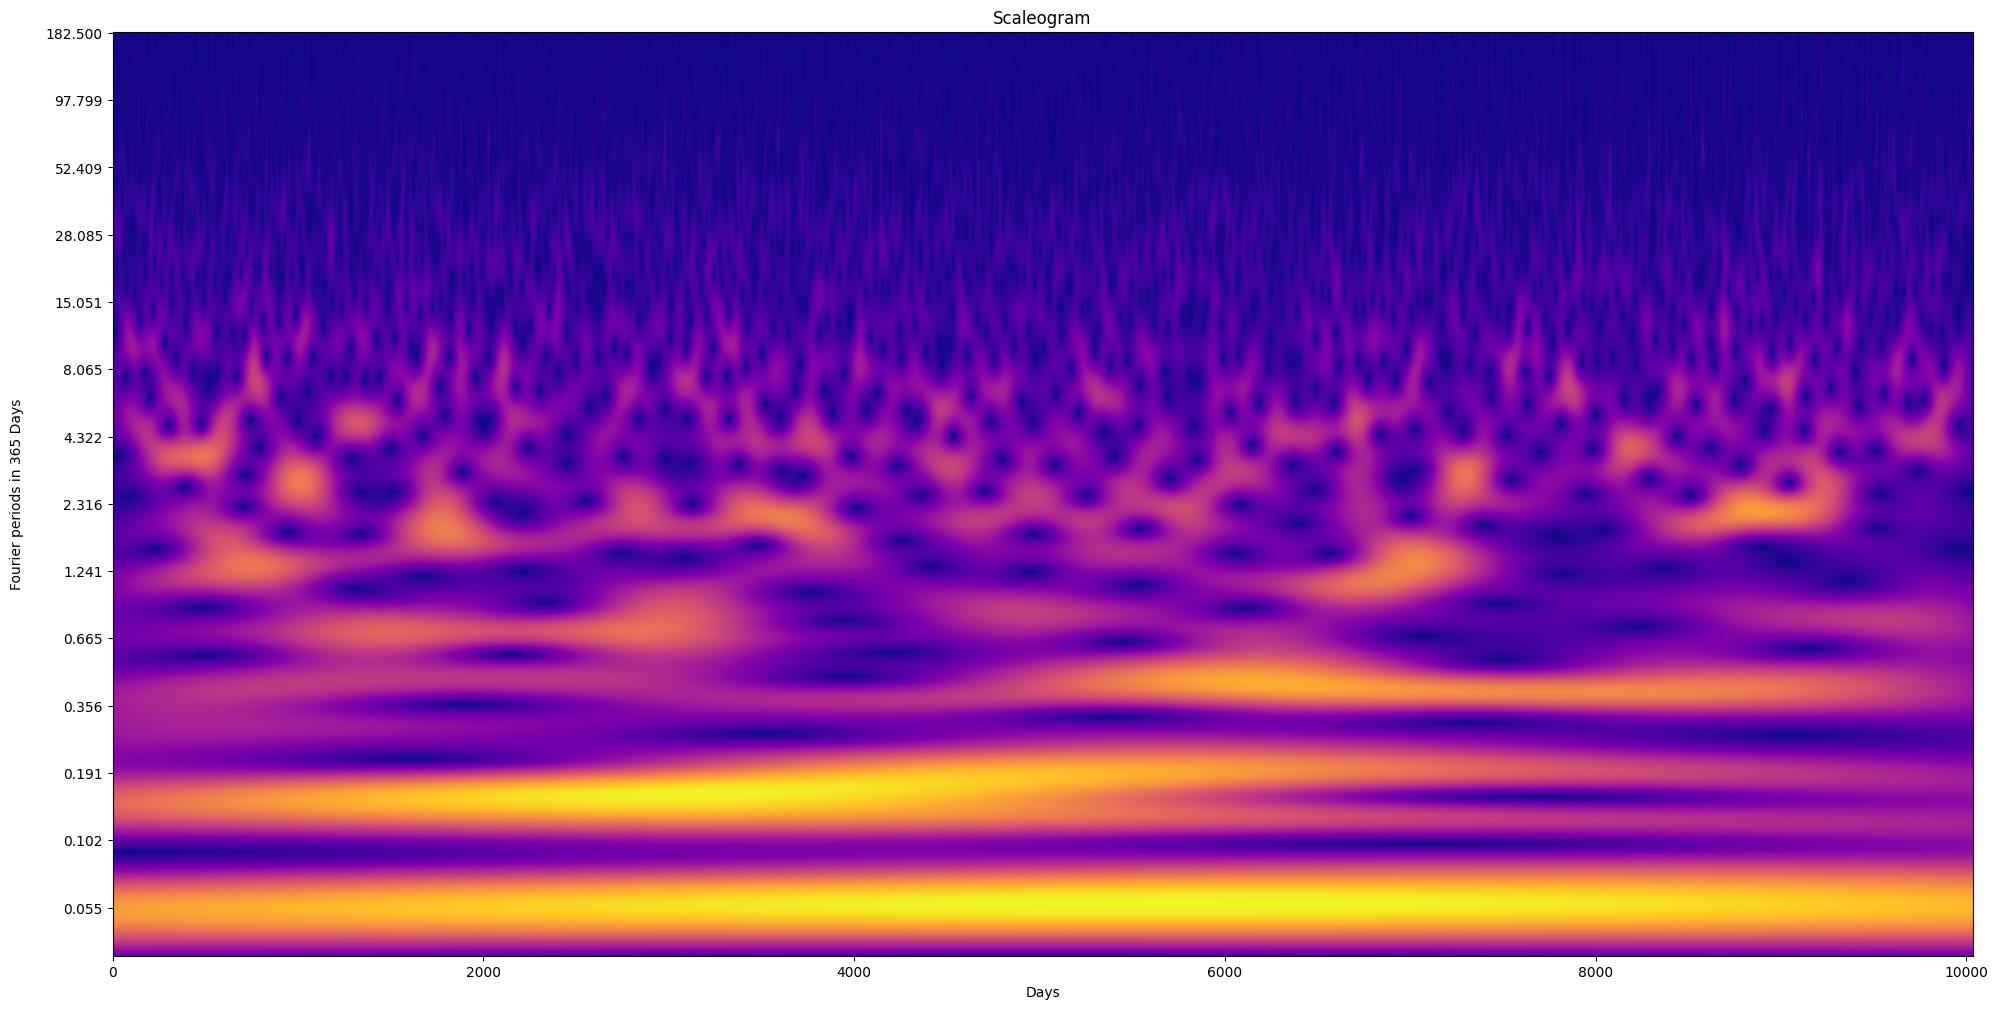

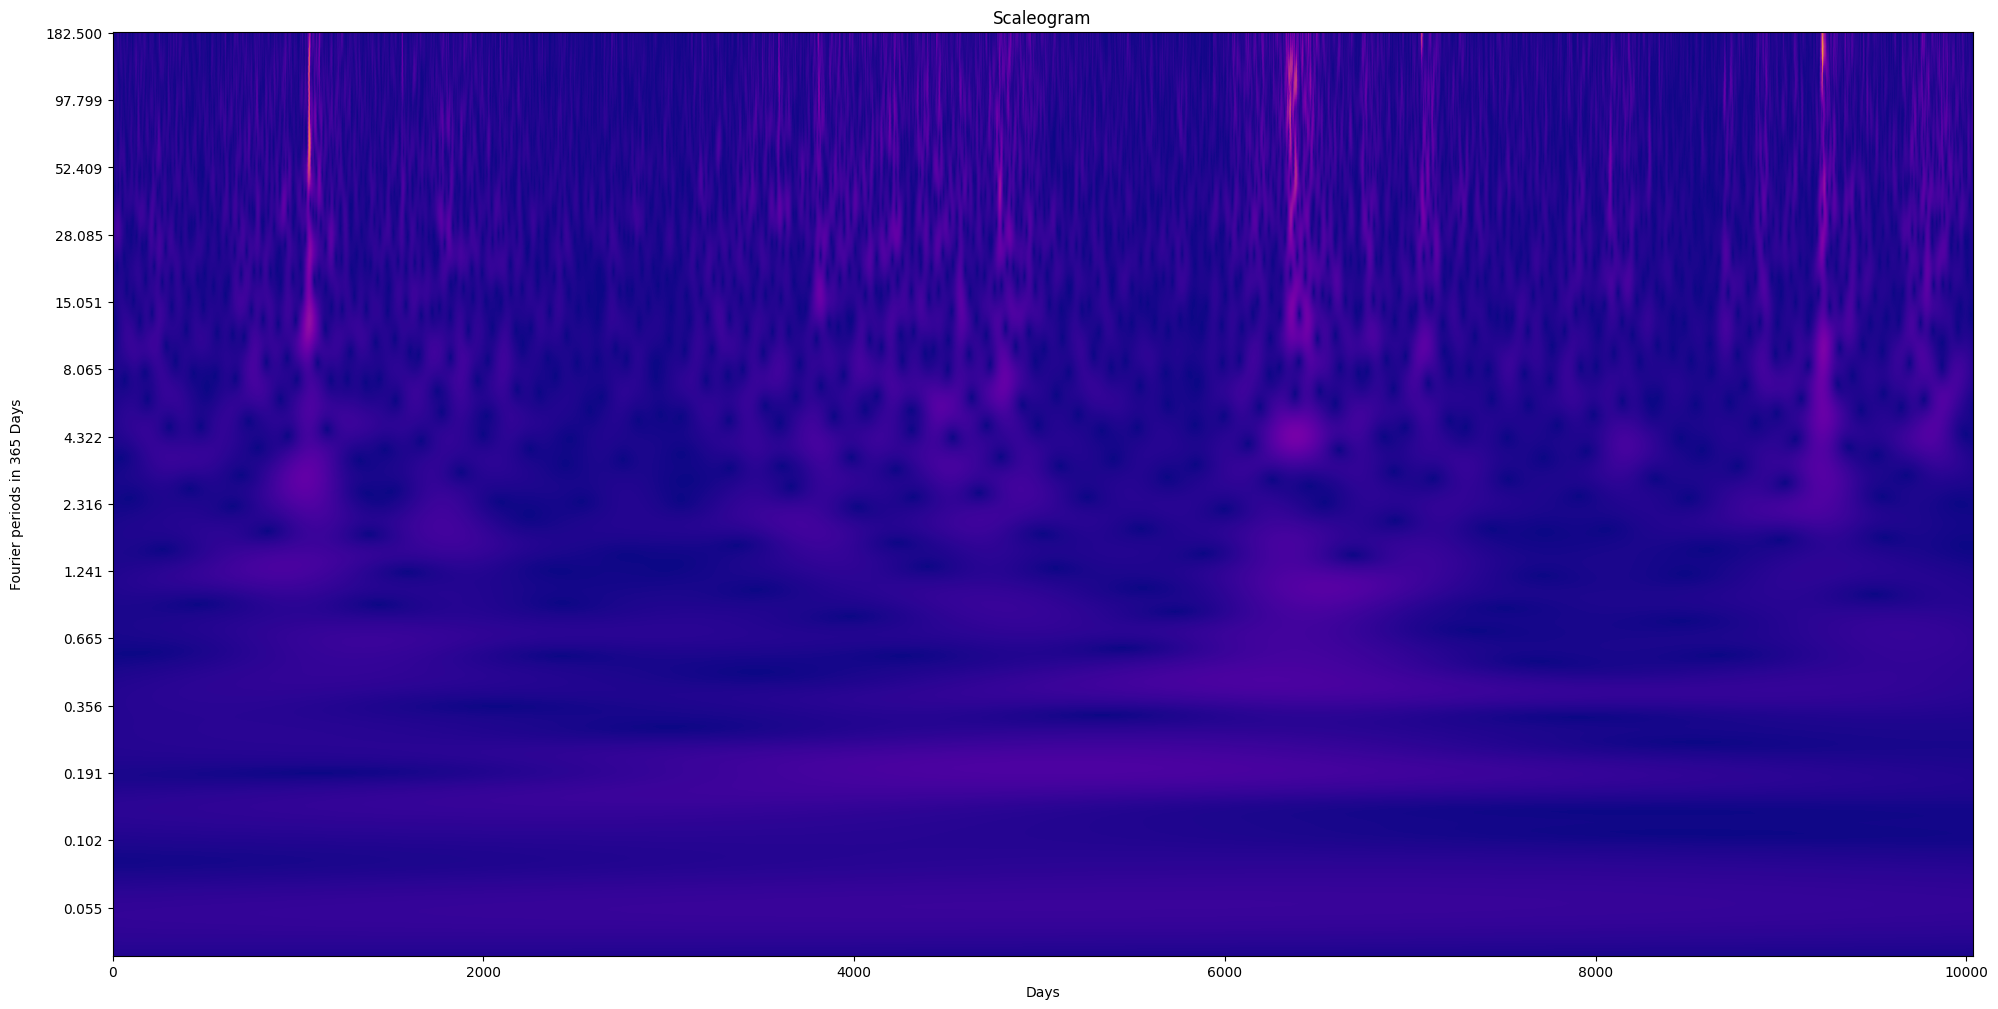

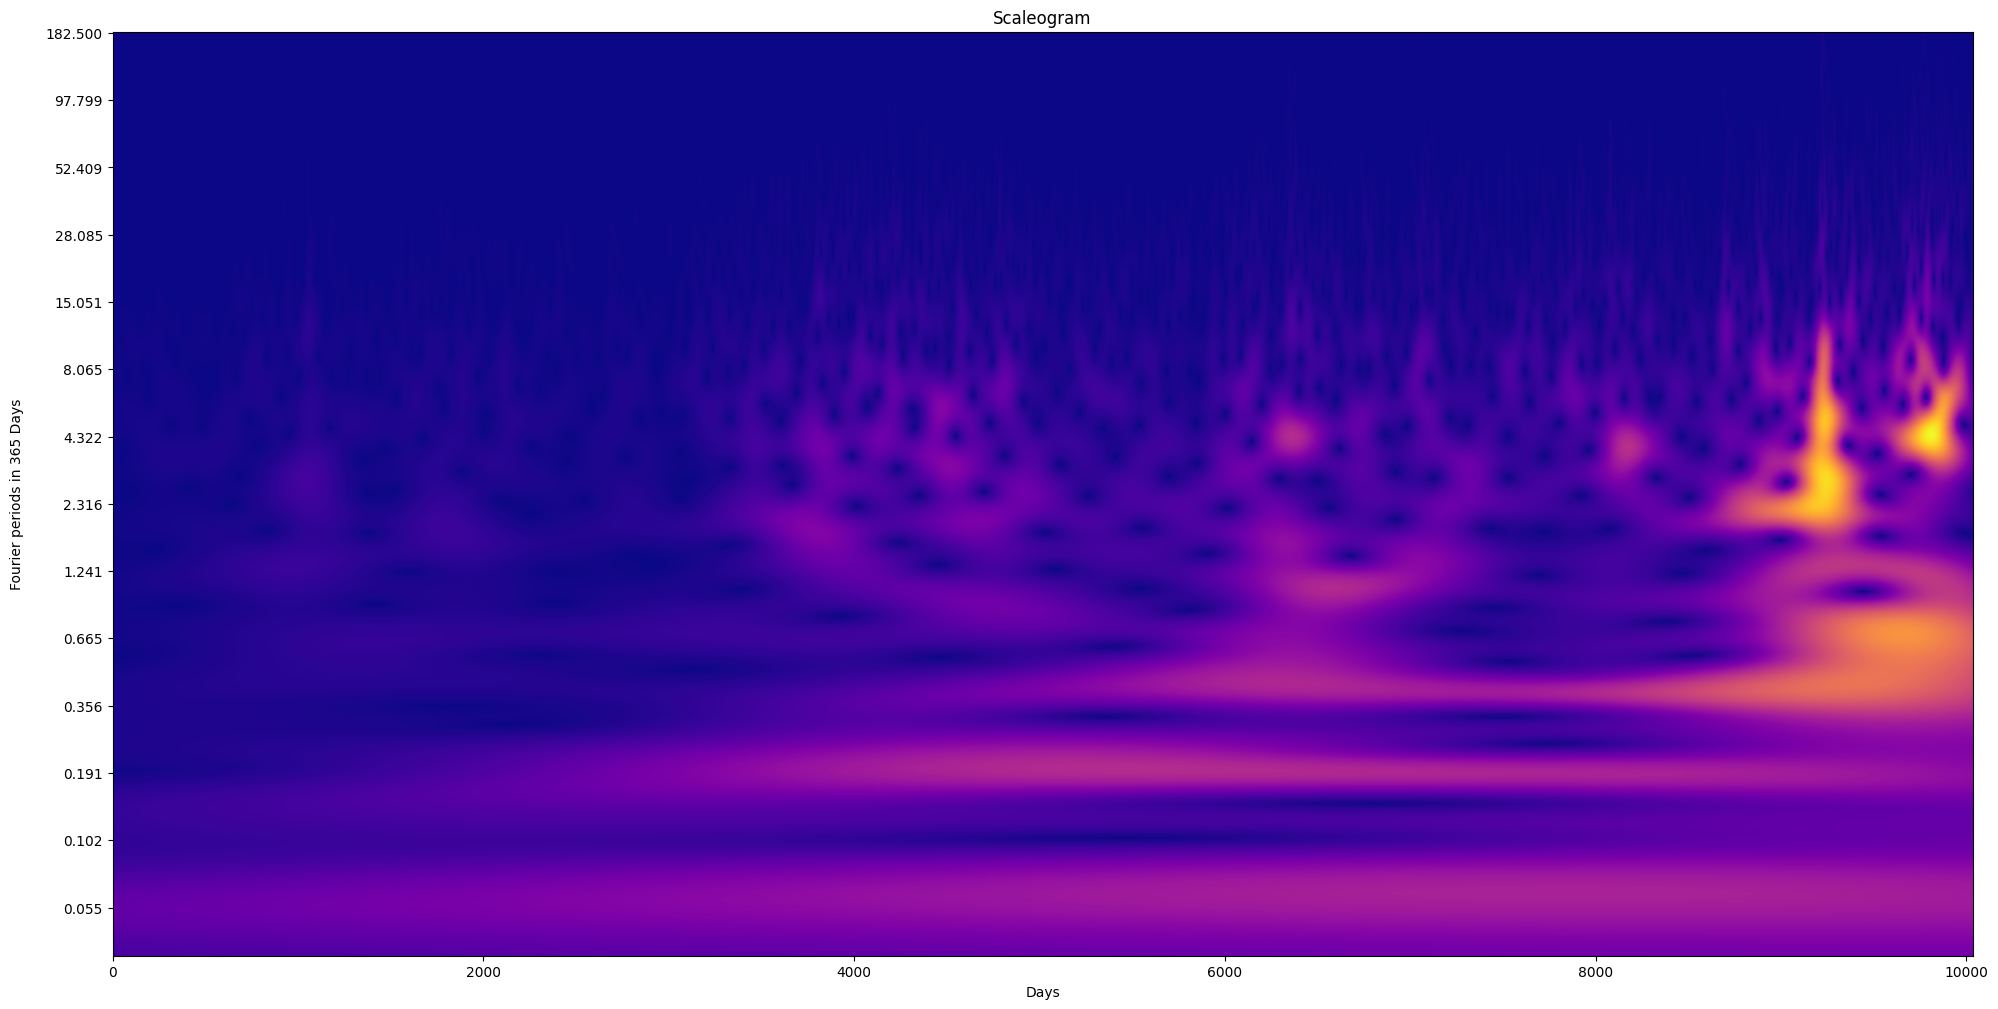

In [5]:
## Prepare model data

#Close(t+1M) > close(t) 
df['shift_adj'] = df.adj_close.shift(-15)
df['label'] = np.nan
for i,j in enumerate(df.index):
    if df.iloc[i].shift_adj > df.iloc[i].adj_close:
        df.loc[j,['label']] = 1
    else:
        df.loc[j,['label']] = 0
df.dropna(inplace=True)

#Volume feature
#vol = wavelet_transform(df.log_vol_diff, wavelet=cwt.Morlet(), dj=0.03, show_sg=True)[0,0].numpy()
#RSI feature
rsi = wavelet_transform(df.rsi_14, wavelet=cwt.Morlet(), dj=0.03, show_sg=True)[0,0].numpy()
#Log returns
ret = wavelet_transform(df.log_ret, wavelet=cwt.Morlet(), dj=0.03, show_sg=True)[0,0].numpy()
#MACD
macd = wavelet_transform(df.macd, wavelet=cwt.Morlet(), dj=0.03, show_sg=True)[0,0].numpy()


<AxesSubplot: xlabel='Date'>

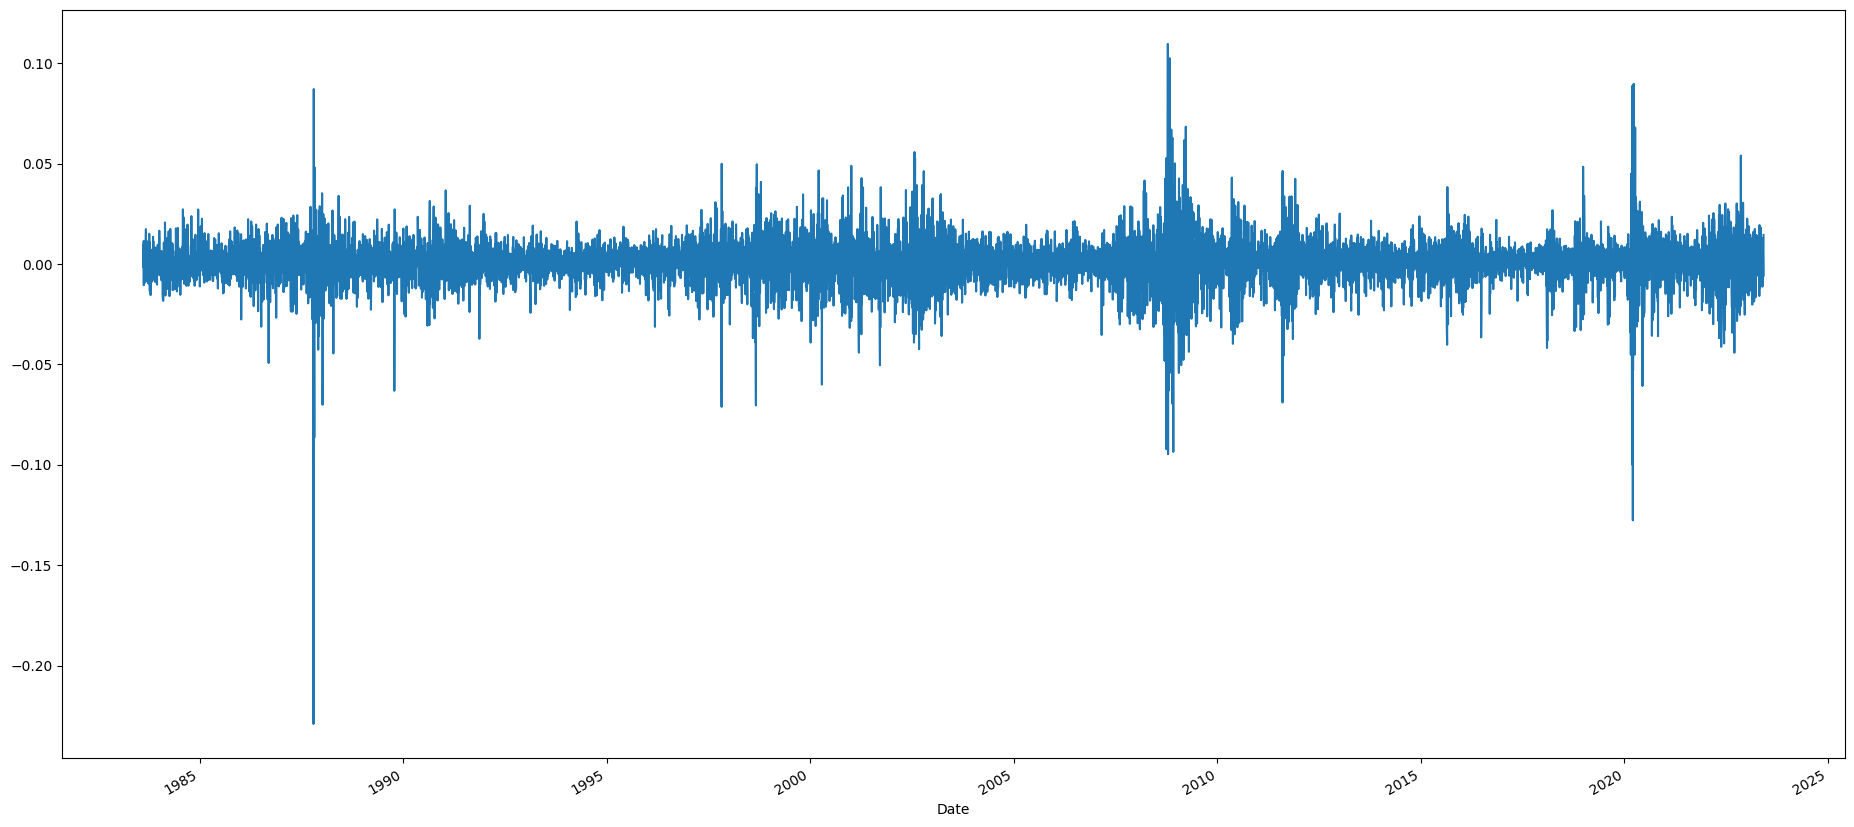

In [6]:
df.log_ret.plot()

In [9]:
## Get feature set from scalograms
window = 30

#Volume set
#vol_set = []
#for i in range(window, vol.shape[1]):
  #  vol_set.append(np.array(vol[:,i-window:i]))
#vol_set = np.array(vol_set)

#RSI set
rsi_set = []
for i in range(window, rsi.shape[1]):
    rsi_set.append(np.array(rsi[:,i-window:i]))
rsi_set = np.array(rsi_set)

#Log returns set
ret_set = []
for i in range(window, ret.shape[1]):
    ret_set.append(np.array(ret[:,i-window:i]))
ret_set = np.array(ret_set)

#MACD set
macd_set = []
for i in range(window, macd.shape[1]):
    macd_set.append(np.array(macd[:,i-window:i]))
macd_set = np.array(macd_set)

#Feature set 
X = np.stack([rsi_set, ret_set, macd_set], axis=3)

#Classification target
y = df[window:].label

#Validation split
X_train = X[:6000]
y_train = y[:6000]
X_val = X[6000:8000]
y_val = y[6000:8000]
X_test = X[8000:]
y_test = y[8000:]



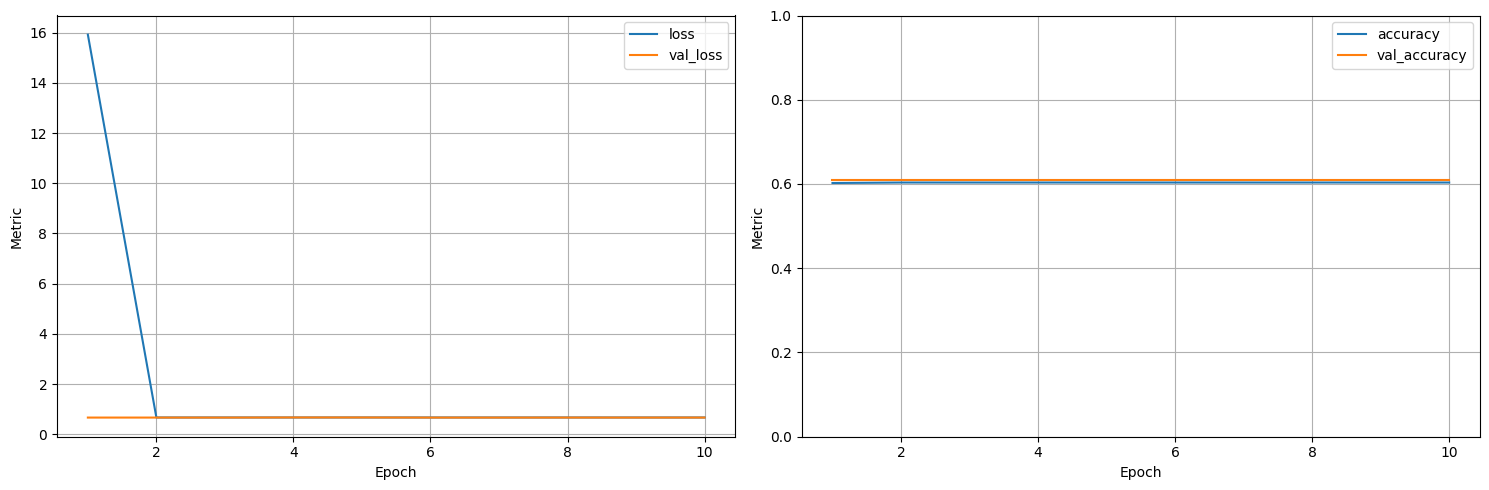

750/750 [==============================] - 63s 84ms/step - loss: 0.6722 - accuracy: 0.6035 - val_loss: 0.6692 - val_accuracy: 0.6105
Train loss: 0.6728583574295044, Train accuracy: 0.6035000085830688
Test loss: 0.6424910426139832, Test accuracy: 0.6611776351928711


In [10]:
## Model
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History, Callback 
history = History()
from IPython.display import clear_output

#Plot learning process
class PlotLearning(Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
            axs[i].set_xlabel('Epoch')
            axs[i].set_ylabel('Metric')
            axs[i].legend()
            axs[i].grid()
        
        axs[1].set_ylim(0,1)

        plt.tight_layout()
        plt.show()
    
#4-channel features
input_shape = (X.shape[1], 30, 3)

#Binary classification 
num_classes = 2
batch_size = 8

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#CNN Model
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape)
         )

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy']
             )
 
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[PlotLearning()]
         )
 
train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

